## Dependencies/Packages/Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install swig
!pip3 install sequitur-g2p
!git clone --recursive https://github.com/petronny/g2p

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.4 MB/s eta 0:00:00
Cloning into 'g2p'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 119 (delta 2), reused 6 (delta 1), pack-reused 108
Receiving objects: 100% (119/119), 193.74 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (55/55), done.
Submodule 'en_us/cmudict' (https://github.com/cmusphinx/cmudict) registered for path 'en_us/cmudict'
Cloning into '/content/g2p/en_us/cmudict'...
remote: Enumerating objects: 238, done.        
remote: Counting objects: 100% (128/128), done.        
remote: Compressing objects: 100% (37/37), done.        
remote: Total 238 (delta 108), reused 96 (delta 91), pack-reused 110        
Receiving objects: 100% (238/238), 3.84 MiB | 9.05 MiB/s, done.
Resolving deltas: 100% (166/166),

In [ ]:
#initial imports
import torch
import torchaudio
from torch import nn
import numpy as np
import math
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
import os
import sys
import librosa
from pathlib import Path
from functools import partial
import unicodedata
import re
from tqdm.contrib.concurrent import process_map, thread_map
from copy import deepcopy
import subprocess
import torchaudio
from g2p.en_us import G2P
from tqdm.notebook import tqdm
import json
import logging
from datetime import datetime
from tornado.log import enable_pretty_logging
from tornado.options import options
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pickle


## Configurations

In [ ]:
class Options(dict):

    def __getitem__(self, key):
        if not key in self.keys():
            self.__setitem__(key, Options())
        return super().__getitem__(key)

    def __getattr__(self, attr):
        if not attr in self.keys():
            self[attr] = Options()
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value

    def __delattr__(self, attr):
        del self[attr]

    def __deepcopy__(self, memo=None):
        new = Options()
        for key in self.keys():
            new[key] = deepcopy(self[key])
        return new

base = Options()
base.max_epochs = 10
base.batch_size = 16
base.learning_rate = 1e-4
base.reduction_rate = 4
base.strategy = 'pretrain'

base.input.num_symbols = 84 + 1
base.input.max_frames = 4500 // base.reduction_rate
base.input.mfcc_dim = 39
base.input.mfcc_dim *= base.reduction_rate

base.text_encoder.num_symbols = base.input.num_symbols
base.text_encoder.embedding_dim = 256
base.text_encoder.prenet.sizes = [256, 128]
base.text_encoder.cbhg.dim = 128
base.text_encoder.cbhg.K = 16
base.text_encoder.cbhg.projections = [128, 128]
base.text_encoder.output_dim = base.text_encoder.cbhg.dim * 2
base.text_encoder.cnn.kernel_size = 5
base.text_encoder.cnn.num_layers = 3

base.speech_encoder.input_dim = base.input.mfcc_dim
base.speech_encoder.cnn.kernel_size = 1 + 2 * int(8/base.reduction_rate)
base.speech_encoder.cnn.filters = [512, 512, 512]
#base.speech_encoder.filters = [32, 32, 64, 64, 128, 128]
#base.speech_encoder.stride = (1, 1)
#base.speech_encoder.kernel_size = (3, 3)
base.speech_encoder.gru_dim = 256
base.speech_encoder.output_dim = base.speech_encoder.gru_dim * 2

base.attention.dim = 128
base.attention.text_input_dim = base.text_encoder.output_dim
base.attention.speech_input_dim = base.speech_encoder.output_dim
base.attention.text_output_dim = base.attention.speech_input_dim
base.attention.speech_output_dim = base.attention.text_input_dim

base.text_decoder.input_dim = base.attention.text_output_dim
base.text_decoder.lstm_dim = 128
base.text_decoder.output_dim = base.input.num_symbols

base.speech_decoder.input_dim = base.attention.speech_output_dim
base.speech_decoder.lstm_dim = 256
base.speech_decoder.output_dim = base.input.mfcc_dim

base.aligner.input_dim = 6
base.aligner.lstm_dim = 32
base.aligner.max_frames = base.input.max_frames
base.aligner.location_layer.attention_n_filters = 32
base.aligner.location_layer.attention_kernel_size = 31
base.aligner.location_layer.output_dim = base.aligner.location_layer.attention_n_filters
base.aligner.cnn.kernel_size = (1 + 2 * int(8/base.reduction_rate), 1 + 2 * int(8/base.reduction_rate))
base.aligner.cnn.filters = [32, 32, 32]
#base.aligner.cnn.kernel_size = (1 + 2 * int(8/base.reduction_rate), 1 + 2 * int(32/base.reduction_rate))
#base.aligner.cnn.filters = [64, 64, 64]

base.predictor.max_frames = 150
base.predictor.input_dim = (base.predictor.max_frames * 2 + 2) * 2 + base.text_encoder.output_dim
#base.predictor.input_dim = (base.predictor.max_frames * 2 + 2) * 2
base.predictor.lstm_dim = 256

base.speech_loss = 1
base.text_loss = 0.1
base.tep_loss = 10
base.mep_loss = 10
base.attention_loss = 1e3
base.attention_loss_alpha = 0.5
base.boundary_loss = 100

temp = deepcopy(base)
temp.attention.text_input_dim = temp.text_encoder.output_dim * 2
temp.attention.speech_input_dim = temp.speech_encoder.output_dim * 2
temp.attention.text_output_dim = temp.attention.speech_input_dim
temp.attention.speech_output_dim = temp.attention.text_input_dim

hparams = temp

# test = deepcopy(base)
# test.batch_size = 32
# test.learning_rate = 1e-3
# test.text_decoder.input_dim = base.text_encoder.output_dim
# test.text_encoder.embedding_dim = 256

# test2 = deepcopy(test)
# test2.batch_size = 256

hparams.reduction_rate

4

## Datasets

### Utilities

In [ ]:
#common classes/functions
class Collate:
    def __init__(self, device=None):
        self.device = device

    def __call__(self, batch):
        length = len(batch[0])
        output = [[] for i in range(length)]

        for data in batch:
            for i, j in enumerate(data):
                if not torch.is_tensor(j):
                    j = torch.from_numpy(j)
                output[i].append(j if self.device is None else j.to(self.device))

        return tuple(output)

class HDFSDatasetFetcher(torch.utils.data._utils.fetch._MapDatasetFetcher):

    def __init__(self, *args, num_readers=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_readers = num_readers

    def fetch(self, possibly_batched_index):
        data = self.dataset.get_items(possibly_batched_index, num_readers=self.num_readers)
        return self.collate_fn(data)

class HDFSIterator(torch.utils.data.dataloader._SingleProcessDataLoaderIter):

    def __init__(self, loader, num_readers=1, **kwargs):
        super().__init__(loader, **kwargs)
        self._dataset_fetcher = HDFSDatasetFetcher(self._dataset, self._auto_collation, self._collate_fn, self._drop_last)

class HDFSLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, num_readers=1, **kwargs):
        kwargs['num_workers'] = 0
        super().__init__(*args, **kwargs)
        self.num_readers = num_readers

    def _get_iterator(self):
        return HDFSIterator(self, num_readers=self.num_readers)

class HDFSDataset(torch.utils.data.Dataset):

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        return self.get_items([index])

class HDFSCollate:

    def __init__(self, device=None):
        self.device = device

    def __call__(self, batch):
        if self.device is None:
            return batch

        for i, data in enumerate(batch):
            for j in range(len(data)):
                if torch.is_tensor(batch[i][j]):
                    batch[i][j] = batch[i][j].to(self.device)
                else:
                    batch[i][j] = torch.from_numpy(batch[i][j]).to(self.device)
        return batch

### Librispeech

In [ ]:
def process_text(g2p, path):
    lines = open(path).readlines()
    lines = [i.strip('\r\n').split(' ') for i in lines]
    for line in lines:
        key = line[0]
        text = ' '.join(line[1:]).lower()
        words = text.split(' ')
        phonemes = []
        for word in words:
            phonemes += g2p.convert(word)
        phonemes = [i[:-1] if i.endswith(('0', '1', '2')) else i for i in phonemes]
        phonemes = [g2p.symbol2id[i] + 1 for i in phonemes if i in g2p.symbols]
        phonemes = np.array(phonemes)
        np.save(path.parent / (key + '.text.npy'), phonemes)

def process_wav(file: Path):
    if not file.exists():
      print(file)
      return
    waveform, sample_rate = librosa.load(file, mono=True)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40), fmax=8000)
    delta = librosa.feature.delta(mfcc, width=3, order=1)
    delta2 = librosa.feature.delta(mfcc, width=3, order=2)
    np.save(file.parent / f'{file.stem}.mfcc.npy', np.concatenate([mfcc, delta, delta2]).T.astype(np.float32))

def get_mean_and_std(mfccs):
    mfccs = np.concatenate(mfccs, axis=0)
    mean = mfccs.mean(axis=0, keepdims=False)
    std = mfccs.std(axis=0, keepdims=False)
    return mean, std

def process_normalization(mfccs_per_speaker):
    mfccs = [np.load(i) for i in mfccs_per_speaker if i.exists()]
    mean, std = get_mean_and_std(mfccs)
    for i, mfcc in enumerate(mfccs):
        mfcc -= mean
        mfcc /= std
        np.save(mfccs_per_speaker[i].parent / (mfccs_per_speaker[i].name[:-8] + 'normalized.mfcc.npy'), mfcc.astype(np.float32))

class LibriSpeech(torch.utils.data.Dataset):

    def __init__(self, path, reduction: int = 1):
        super().__init__()
        self.path = Path(path)
        self.wavs = [i for i in self.path.rglob('*.flac')]
        self.texts = [Path(str(i)[:-4] + 'text.npy') for i in self.wavs]
        self.mfccs = [Path(str(i)[:-4] + 'mfcc.npy') for i in self.wavs]
        self.normalized_mfccs = [Path(str(i)[:-4] + 'normalized.mfcc.npy') for i in self.wavs]
        self.reduction = reduction

    def __len__(self):
        return len(self.wavs)

    def __getitem__(self, index):
        text = np.load(self.texts[index])
        mfcc = np.load(self.normalized_mfccs[index])

        if mfcc.shape[0] % self.reduction != 0:
            mfcc = np.concatenate([mfcc, np.zeros((self.reduction - mfcc.shape[0] % self.reduction, mfcc.shape[1]))])
        if self.reduction > 1:
            mfcc = mfcc.reshape(mfcc.shape[0] // self.reduction, mfcc.shape[1] * self.reduction)

        return text, mfcc.astype(np.float32)

In [ ]:
# data = torchaudio.datasets.LIBRISPEECH(
#     './',
#     'train-clean-360',
#     'LibriSpeech',
#     download = True)

# dataset = LibriSpeech('./LibriSpeech', reduction=1)

# if not dataset.texts[0].exists():
#     g2p = G2P()
#     texts = [i for i in dataset.path.rglob('*.trans.txt')]
#     thread_map(partial(process_text, g2p), texts)

# if not dataset.mfccs[0].exists():
#     thread_map(process_wav, dataset.wavs)

# if not dataset.normalized_mfccs[0].exists():
#     mfccs_per_speaker = {}
#     for i in dataset.mfccs:
#         name = i.parents[1].name
#         if not name in mfccs_per_speaker:
#             mfccs_per_speaker[name] = [i]
#         else:
#             mfccs_per_speaker[name].append(i)

#     thread_map(process_normalization, mfccs_per_speaker.values())

100%|██████████| 21.5G/21.5G [03:53<00:00, 98.7MB/s]


  0%|          | 0/2097 [00:00<?, ?it/s]

  0%|          | 0/104014 [00:00<?, ?it/s]

  0%|          | 0/921 [00:00<?, ?it/s]

In [ ]:
# data = torchaudio.datasets.LIBRISPEECH(
#     './',
#     'train-clean-100',
#     'LSTrain',
#     download = True)

# dataset = LibriSpeech('./LibriSpeech', reduction=4)

# g2p = G2P()
# texts = [i for i in dataset.path.rglob('*.trans.txt')]
# _ = thread_map(partial(process_text, g2p), texts)

# _ = thread_map(process_wav, dataset.wavs)

# mfccs_per_speaker = {}
# for i in dataset.mfccs:
#     name = i.parents[1].name
#     if not name in mfccs_per_speaker:
#         mfccs_per_speaker[name] = [i]
#     else:
#         mfccs_per_speaker[name].append(i)

# _ = thread_map(process_normalization, mfccs_per_speaker.values())

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/28539 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
dataset = LibriSpeech('./LibriSpeech', reduction=1)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=Collate('cuda:0'), drop_last=True)
for batch in data_loader:
    for _list in batch:
        print([i.shape for i in _list])
    break

In [ ]:
!cp ./drive/MyDrive/LS360.zip ./LS360.zip

^C


In [ ]:
!unzip ./drive/MyDrive/LS360.zip -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0003.text.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0026.flac  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0011.flac  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0000.text.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0023.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0002.text.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0019.text.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0010.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0013.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0001.normalized.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0015.flac  
  inflating: ./LibriSpeech/train-clean-360/925/8140/925-8140-0022.text.npy  
  inflating: ./LibriSpeech

In [ ]:
!unzip -o ./drive/MyDrive/LS100.zip -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0041.normalized.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0058.normalized.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0006.normalized.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0060.text.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0007.flac  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0059.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0014.text.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0015.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0031.normalized.mfcc.npy  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0055.flac  
  inflating: ./LibriSpeech/train-clean-100/2989/138028/2989-138028-0009.flac  
  in

### LJSpeech

In [ ]:
punctuation_re = re.compile(r'[.,?!’"“”:;-]')
comment_re = re.compile(r'\[[^]]*\]')

def process_text(path, g2p, line):
    line = line.strip('\r\n').split('|')
    text, _ = punctuation_re.subn(' ', line[-1].lower())
    text, _ = comment_re.subn(' ', text)
    text = ''.join([i for i in unicodedata.normalize('NFKD', text) if not unicodedata.combining(i)])
    words = text.split(' ')
    words = [i for i in words if i != '']
    phonemes = []
    for word in words:
        phonemes += g2p.convert(word)
    phonemes = [i[:-1] if i.endswith(('0', '1', '2')) else i for i in phonemes]
    phonemes = [g2p.symbol2id[i] + 1 for i in phonemes if i in g2p.symbols]
    phonemes = np.array(phonemes)
    np.save(path / 'wavs' / (line[0] + '.text.npy'), phonemes)

def process_wav(file: Path, sample_rate=22050):
    waveform, _ = librosa.load(file, sr=sample_rate, mono=True)
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40), fmax=8000)
    delta = librosa.feature.delta(mfcc, width=3, order=1)
    delta2 = librosa.feature.delta(mfcc, width=3, order=2)
    np.save(file.parent / (file.name[:-3] + 'mfcc.npy'), np.concatenate([mfcc, delta, delta2]).T.astype(np.float32))

def get_mean_and_std(mfccs):
    mfccs = np.concatenate(mfccs, axis=0)
    mean = mfccs.mean(axis=0, keepdims=False)
    std = mfccs.std(axis=0, keepdims=False)
    return mean, std

def normalize(mean, standard, inputs):
    file, mfcc = inputs
    mfcc -= mean
    mfcc /= standard
    np.save(file.parent / (file.name[:-3] + 'normalized.mfcc.npy'), mfcc.astype(np.float32))

class LJSpeech(torch.utils.data.Dataset):

    def __init__(self, path, reduction: int = 1):
        super().__init__()
        self.path = Path(path)
        self.wavs = [i for i in self.path.rglob('*.wav')]
        self.texts = [Path(str(i)[:-3] + 'text.npy') for i in self.wavs]
        self.mfccs = [Path(str(i)[:-3] + 'mfcc.npy') for i in self.wavs]
        self.normalized_mfccs = [Path(str(i)[:-3] + 'normalized.mfcc.npy') for i in self.wavs]
        self.reduction = reduction

    def __len__(self):
        return len(self.wavs)

    def __getitem__(self, index):
        text = np.load(self.texts[index])
        mfcc = np.load(self.normalized_mfccs[index])

        if mfcc.shape[0] % self.reduction != 0:
            mfcc = np.concatenate([mfcc, np.zeros((self.reduction - mfcc.shape[0] % self.reduction, mfcc.shape[1]))])
        if self.reduction > 1:
            mfcc = mfcc.reshape(mfcc.shape[0] // self.reduction, mfcc.shape[1] * self.reduction)

        return text, mfcc.astype(np.float32)

In [ ]:
# torchaudio.datasets.LJSPEECH('./', 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2', 'wavs', download = True)
# dataset = LJSpeech('LJSpeech', reduction=4)
# lines = open(dataset.path / 'metadata.csv').readlines()

# if not dataset.texts[0].exists():
#     g2p = G2P()
#     thread_map(partial(process_text, dataset.path, g2p), lines, chunksize=1)

# if not dataset.mfccs[0].exists():
#     thread_map(process_wav, dataset.wavs)

# if not dataset.normalized_mfccs[0].exists():
#     mfccs = thread_map(np.load, dataset.mfccs)
#     mean, std = get_mean_and_std(mfccs)
#     thread_map(partial(normalize, mean, std), [i for i in zip(dataset.wavs, mfccs)])

# data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=Collate('cuda:0'), drop_last=True)
# for batch in data_loader:
#     for _list in batch:
#         print([i.shape for i in _list])
#         print(_list[1])
#     break

### Buckeye

In [ ]:
phoneme_map = {
        'a': 'AH',
        'e': 'EH',
        'h': 'HH',
        'i': 'IH',

        'tq': 'T',
        'q': 'TH',
        'id': 'D',

        'dx': ['D', 'Z'],
        'nx': ['N', 'Z'],
        'aan': ['AA', 'N'],
        'aen': ['AE', 'N'],
        'ahn': ['AH', 'N'],
        'aon': ['AO', 'N'],
        'awn': ['AW', 'N'],
        'ayn': ['AY', 'N'],
        'ehn': ['EH', 'N'],
        'ern': ['ER', 'N'],
        'eyn': ['EY', 'N'],
        'hhn': ['HH', 'N'],
        'ihn': ['IH', 'N'],
        'iyn': ['IY', 'N'],
        'own': ['OW', 'N'],
        'oyn': ['OY', 'N'],
        'uhn': ['UH', 'N'],
        'uwn': ['UW', 'N'],

        'ah l': ['AH', 'L'],
        'ah n': ['AH', 'N'],
        'ah r': ['AH', 'R'],
        'ih l': ['IH', 'L'],

        'en': ['AE', 'N'],
        'em': ['AH', 'M'],
        'el': ['AH', 'L'],
        'eng': ['IH', 'NG'],
}

class Word:

    def __init__(self, content=None, start=None, end=None):
        self.content = content
        self.start = start
        self.end = end

class Phoneme(Word):
    pass

class Sentence:

    def __init__(self, start=None, end=None):
        self.start = start
        self.end = end
        self.words = [Word(start=start)]

    def __str__(self):
        return str([word.content for word in self.words])

def clip_wav(source, start, end, target):
    duration = '%.6f' % (end - start)
    start = '%.6f' % start
    subprocess.run(['ffmpeg', '-i', source, '-ss', start, '-t', duration, target, '-v', 'quiet', '-y'])

def process_segmentation(segmented, g2p, path):
    lines = open(path).readlines()[9:]
    lines = [line.strip('\r\n') for line in lines]

    sentences = []
    for line in lines:
        line = line.split(';')[0].split(' ')
        line = [i for i in line if i != '']
        if len(line) == 0:
            continue
        if len(line) > 3:
            line[2] = ' '.join(line[2:])
            del line[3:]
            if not line[2].startswith('<') or not line[-1].endswith('>'):
                print('Invaild word:', path, line[2])
        word = line[2]
        time = float(line[0])
        if word in ['{B_TRANS}', '<IVER>', '{E_TRANS}', '<VOCNOISE>', '<SIL>']:
            if len(sentences) > 0 and sentences[-1].end is None:
                sentences[-1].end = sentences[-1].words[-1].end
            sentences.append(Sentence(start=time))
        else:
            if len(sentences) == 0:
                sentences.append(Sentence(start=0))
            if sentences[-1].words[-1].end is None:
                sentences[-1].words[-1].end = time
                sentences[-1].words[-1].content = word
            else:
                sentences[-1].words.append(Word(content=word, start=sentences[-1].words[-1].end, end=time))

    lines = open(path.parent/ (path.stem + '.phones')).readlines()[9:]
    lines = [line.strip('\r\n') for line in lines]

    phonemes = []
    start = 0
    for line in lines:
        line = line.split(';')[0].split(' ')
        line = [i for i in line if i != '']
        if len(line) == 0:
            continue
        if len(line) > 3:
            line[2] = ' '.join(line[2:])
            del line[3:]
            if not line[2].startswith('<') or not line[-1].endswith('>'):
                print('Invaild phoneme:', path.stem + '.phones', line[2])
        time = float(line[0])
        if len(line) < 3:
            if phonemes[-1].end is None:
                phonemes[-1].end = time
            continue
        phoneme = line[2].replace('+1', '')
        if len(phonemes) == 0:
            phonemes.append(Phoneme(content=phoneme, start=0, end=time))
        else:
            phonemes.append(Phoneme(content=phoneme, start=phonemes[-1].end, end=time))

    for i, sentence in enumerate(sentences):
        try:
            sentence.words = [word for word in sentence.words if not word.content.startswith('<')]
        except:
            continue

        if len(sentence.words) == 0:
            continue

        if sentence.start is None or sentence.end is None:
            print('Ignored invalid sentence:', sentence)
            continue

        if sentence.end - sentence.start <= 0.025:
            continue

        clip_wav(path.parent / (path.stem + '.wav'), sentence.start, sentence.end, segmented / ('%s-%03d.wav' % (path.stem, i)))

        lines = []

        for word in sentence.words:
            lines.append('%.6f\t%.6f\t%s' % (word.start - sentence.start, word.end - sentence.start, word.content))

        lines = [line + '\n' for line in lines]
        with open(segmented / ('%s-%03d.words' % (path.stem, i)), 'w') as f:
            f.writelines(lines)

        lines = []
        _phonemes = [j for j in phonemes if sentence.start <= j.start and j.end <= sentence.end]
        for phoneme in _phonemes:
            if phoneme.content.upper() in g2p.symbols:
                lines.append('%.6f\t%.6f\t%s' % (phoneme.start - sentence.start, phoneme.end - sentence.start, phoneme.content.upper()))
            elif phoneme.content in phoneme_map.keys():
                if type(phoneme_map[phoneme.content]) is list:
                    for j, p in enumerate(phoneme_map[phoneme.content]):
                        if j == 0:
                            lines.append('%.6f\t%.6f\t%s' % (phoneme.start - sentence.start, -1, p))
                        elif j == len(phoneme_map[phoneme.content]) - 1:
                            lines.append('%.6f\t%.6f\t%s' % (-1, phoneme.end - sentence.start, p))
                        else:
                            lines.append('%.6f\t%.6f\t%s' % (-1, -1, p))
                else:
                    lines.append('%.6f\t%.6f\t%s' % (phoneme.start - sentence.start, phoneme.end - sentence.start, phoneme_map[phoneme.content]))
            elif phoneme.content in ['{B_TRANS}', '{E_TRANS}', 'VOCNOISE', 'SIL', 'IVER', 'LAUGH', '<EXCLUDE-name>', 'UNKNOWN', 'NOISE', 'IVER-LAUGH', '<exclude-Name>']:
                continue
            else:
                print('Unknown phoneme', path.stem, i, phoneme.content)
                lines.append('%.6f\t%.6f\t%s' % (phoneme.start - sentence.start, phoneme.end - sentence.start, phoneme.content))

        with open(segmented / ('%s-%03d.phonemes' % (path.stem, i)), 'w') as f:
            f.write('\n'.join(lines))

def process_word(g2p, path):
    lines = open(path).readlines()
    lines = [i.strip('\r\n') for i in lines]
    lines = [i.split('\t') for i in lines]
    words = [i[2] for i in lines]

    phonemes = []
    for word in words:
        phonemes += g2p.convert(word)
    phonemes = [g2p.symbol2id[i] + 1 for i in phonemes if i in g2p.symbols]
    if len(phonemes) == 0:
        print('Removing sentence with no phoneme:', path)
        for i in path.parent.rglob(f'{path.stem}.*'):
            i.unlink()
        return

    phonemes = np.array(phonemes)
    np.save(path.parent / (path.stem + '.word.npy'), phonemes)

    result = []
    for i, word in enumerate(words):
        phonemes = g2p.convert(word)
        result.append(np.zeros((len(phonemes), 2)) - 1)
        result[-1][0, 0] = float(lines[i][0])
        result[-1][-1, 1] = float(lines[i][1])

    result = np.concatenate(result)
    np.save(path.parent / (path.stem + '.word.boundary.npy'), result)

def process_phoneme(g2p, path):
    lines = open(path).readlines()
    lines = [line.strip('\r\n') for line in lines]
    lines = [line.split('\t') for line in lines]

    phonemes = [i[2] for i in lines]
    if False in [phoneme in g2p.symbols for phoneme in phonemes]:
        print('Removing sentence with unknown phoneme:', path)
        for i in path.parent.rglob(f'{path.stem}.*'):
            i.unlink()
        return

    phonemes = [g2p.symbol2id[i] + 1 for i in phonemes if i in g2p.symbols]
    if len(phonemes) == 0:
        print('Removing sentence with no phoneme:', path)
        for i in path.parent.rglob(f'{path.stem}.*'):
            i.unlink()
        return

    phonemes = np.array(phonemes)
    np.save(path.parent / (path.stem + '.phoneme.npy'), phonemes)

    result = np.zeros((len(lines), 2))
    for i, line in enumerate(lines):
        result[i, 0] = float(line[0])
        result[i, 1] = float(line[1])

    np.save(path.parent / (path.stem + '.phoneme.boundary.npy'), result)

def process_wav(file: Path, sample_rate=16000):
    waveform, sample_rate = librosa.load(file, sr=sample_rate, mono=True)
    if len(waveform) == 0:
        print('Removing empty wav:', file)
        for i in file.parent.rglob(f'{file.stem}.*'):
            i.unlink()
        return
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40), fmax=8000)
    delta = librosa.feature.delta(mfcc, width=3, order=1)
    delta2 = librosa.feature.delta(mfcc, width=3, order=2)
    np.save(file.parent / (file.name[:-3] + 'mfcc.npy'), np.concatenate([mfcc, delta, delta2]).T.astype(np.float32))

def get_mean_and_std(mfccs):
    mfccs = np.concatenate(mfccs, axis=0)
    mean = mfccs.mean(axis=0, keepdims=False)
    std = mfccs.std(axis=0, keepdims=False)
    return mean, std

def process_normalization(mfccs_per_speaker):
    mfccs = [np.load(i) for i in mfccs_per_speaker]
    mean, std = get_mean_and_std(mfccs)
    for i, mfcc in enumerate(mfccs):
        mfcc -= mean
        mfcc /= std
        np.save(mfccs_per_speaker[i].parent / (mfccs_per_speaker[i].name[:-8] + 'normalized.mfcc.npy'), mfcc.astype(np.float32))

class Buckeye(torch.utils.data.Dataset):

    def __init__(self, path, reduction: int = 1, wavs = None):
        super().__init__()
        self.path = Path(path)
        self.segmented = self.path / 'segmented'
        if not wavs:
          self.wavs = [i for i in self.segmented.rglob('*.wav')]
        else:
          self.wavs = wavs
        self.words = [Path(str(i)[:-3] + 'word.npy') for i in self.wavs]
        self.phonemes = [Path(str(i)[:-3] + 'phoneme.npy') for i in self.wavs]
        self.word_boundaries = [Path(str(i)[:-3] + 'word.boundary.npy') for i in self.wavs]
        self.phoneme_boundaries = [Path(str(i)[:-3] + 'phoneme.boundary.npy') for i in self.wavs]
        self.mfccs = [Path(str(i)[:-3] + 'mfcc.npy') for i in self.wavs]
        self.normalized_mfccs = [Path(str(i)[:-3] + 'normalized.mfcc.npy') for i in self.wavs]
        self.reduction = reduction

    def __len__(self):
        return len(self.wavs)

    def __getitem__(self, index):
        word = np.load(self.words[index])
        word_boundary = np.load(self.word_boundaries[index])
        mfcc = np.load(self.normalized_mfccs[index])

        if mfcc.shape[0] % self.reduction != 0:
            mfcc = np.concatenate([mfcc, np.zeros((self.reduction - mfcc.shape[0] % self.reduction, mfcc.shape[1]))])
        if self.reduction > 1:
            mfcc = mfcc.reshape(mfcc.shape[0] // self.reduction, mfcc.shape[1] * self.reduction)

        return word, mfcc.astype(np.float32), word_boundary.astype(np.float32)

class BuckeyePhoneme(Buckeye):

    def __getitem__(self, index):
        phoneme = np.load(self.phonemes[index])
        phoneme_boundary = np.load(self.phoneme_boundaries[index])
        mfcc = np.load(self.normalized_mfccs[index])

        if mfcc.shape[0] % self.reduction != 0:
            mfcc = np.concatenate([mfcc, np.zeros((self.reduction - mfcc.shape[0] % self.reduction, mfcc.shape[1]))])
        if self.reduction > 1:
            mfcc = mfcc.reshape(mfcc.shape[0] // self.reduction, mfcc.shape[1] * self.reduction)

        return phoneme, mfcc.astype(np.float32), phoneme_boundary.astype(np.float32)

In [ ]:
!zip -r ./BuckeyePredicted.zip ./Buckeye

In [ ]:
!cp drive/MyDrive/BuckeyeClean.zip ./
# !unzip ./BuckeyeFinal.zip -d ./Buckeye
# !find BuckeyeFinal.zip
!unzip ./BuckeyeClean.zip -d ./

In [ ]:
!cp BuckeyePredicted.zip ./drive/MyDrive/BuckeyePredicted.zip

In [ ]:
import random, os
if not os.path.isdir('./dud'):
    os.mkdir('./dud')
def train_test_split(wav_list, path):
    random.shuffle(wav_list)
    train_wavs = wav_list[:len(wav_list)//4*3]
    test_wavs = wav_list[len(wav_list)//4*3:]

    wav_list = train_wavs
    words = [Path(str(i)[:-3] + 'word.npy') for i in wav_list]
    phonemes = [Path(str(i)[:-3] + 'phoneme.npy') for i in wav_list]
    word_boundaries = [Path(str(i)[:-3] + 'word.boundary.npy') for i in wav_list]
    phoneme_boundaries = [Path(str(i)[:-3] + 'phoneme.boundary.npy') for i in wav_list]
    mfccs = [Path(str(i)[:-3] + 'mfcc.npy') for i in wav_list]
    normalized_mfccs = [Path(str(i)[:-3] + 'normalized.mfcc.npy') for i in wav_list]
    train_set, train_setp = Buckeye('./dud', reduction=1), BuckeyePhoneme('./dud', reduction=1)
    train_set.path = train_setp.path = Path(path)
    train_set.segmented = train_setp.segmented = train_setp.path / 'segmented'
    train_set.wavs = train_setp.wavs = wav_list
    train_set.words = train_setp.words = words
    train_set.phonemes = train_setp.phonemes = phonemes
    train_set.word_boundaries = train_setp.word_boundaries = word_boundaries
    train_set.phoneme_boundaries = train_setp.phoneme_boundaries = phoneme_boundaries
    train_set.mfccs = train_setp.mfccs = mfccs
    train_set.normalized_mfccs = train_setp.normalized_mfccs = normalized_mfccs

    wav_list = test_wavs
    print(len(wav_list))
    words = [Path(str(i)[:-3] + 'word.npy') for i in wav_list]
    phonemes = [Path(str(i)[:-3] + 'phoneme.npy') for i in wav_list]
    word_boundaries = [Path(str(i)[:-3] + 'word.boundary.npy') for i in wav_list]
    phoneme_boundaries = [Path(str(i)[:-3] + 'phoneme.boundary.npy') for i in wav_list]
    mfccs = [Path(str(i)[:-3] + 'mfcc.npy') for i in wav_list]
    normalized_mfccs = [Path(str(i)[:-3] + 'normalized.mfcc.npy') for i in wav_list]
    test_set, test_setp = Buckeye('./dud', reduction=1), BuckeyePhoneme('./dud', reduction=1)
    test_set.path = test_setp.path = Path(path)
    test_set.segmented = test_setp.segmented = test_setp.path / 'segmented'
    test_set.wavs = test_setp.wavs = wav_list
    test_set.words = test_setp.words = words
    test_set.phonemes = test_setp.phonemes = phonemes
    test_set.word_boundaries = test_setp.word_boundaries = word_boundaries
    test_set.phoneme_boundaries = test_setp.phoneme_boundaries = phoneme_boundaries
    test_set.mfccs = test_setp.mfccs = mfccs
    test_set.normalized_mfccs = test_setp.normalized_mfccs = normalized_mfccs

    return train_set, train_setp, test_set, test_setp


In [ ]:
g2p = G2P()
dataset_word = Buckeye('./Buckeye/Buckeye', reduction=1)
prelim, prelim_p, test_set, test_set_p = train_test_split(dataset_word.wavs, './Buckeye/Buckeye')
train_set, train_setp, valid_set, valid_setp = train_test_split(prelim.wavs, './Buckeye/Buckeye')

In [ ]:
import pickle as pkl
with open('./Buckeye/train_set.pkl', 'wb') as file:
  pkl.dump(train_set.wavs, file)
with open('./Buckeye/test_set.pkl', 'wb') as file:
  pkl.dump(test_set.wavs, file)
with open('./Buckeye/valid_set.pkl', 'wb') as file:
  pkl.dump(valid_set.wavs, file)

In [ ]:
!cp ./drive/MyDrive/BuckeyeClean.zip ./
!unzip -q ./BuckeyeClean.zip -d ./

## IFA Dataset

In [ ]:
!cp ./drive/MyDrive/ifadataset.zip ./
!unzip -q ./ifadataset.zip -d ./

In [ ]:
!zip -r -q ./ifadataset.zip ./ifadata
!cp ./ifadataset.zip ./drive/MyDrive/ifapredicted.zip

In [ ]:
!cp ./drive/MyDrive/ifapredicted.zip ./
!unzip -q ./ifapredicted.zip -d ./

In [ ]:
labels = Path('./ifadata/labels/')
wavs = Path('./ifadata/wavs/')
segmented_audio = Path('./ifadata/segmented/')
phoneme_folder = Path('./ifadata/phonemes/')
boundary_folder = Path('./ifadata/boundaries/')
phoneme_data = Path('./ifadata/phoneme_data/')
mfcc_folder = Path('./ifadata/mfccs/')
nmfccs = Path('./ifadata/nmfccs/')

# ct = 0
# for i in [i for i in os.listdir(phoneme_folder) if i[-3:] != 'txt']:
#   if not os.path.exists(nmfccs / f'{i[:-8]}.normalized.mfcc.npy'):
#     os.remove(phoneme_folder / i)
#     os.remove(phoneme_data / f'{i[:-8]}.phoneme.npy')
#     os.remove(boundary_folder / f'{i[:-8]}.phoneme.boundary.npy')

In [ ]:
import wave
import contextlib

def get_duration(file_stub, dataset = 'IFA'):
    fname = segmented_audio / f'{file_stub}.wav' if dataset == 'IFA' else file_stub
    with contextlib.closing(wave.open(str(fname),'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
    return duration

def above_duration(file_stub, minimum):
    return get_duration(file_stub) >= minimum

class IFAPhoneme(torch.utils.data.Dataset):

    def __init__(self, reduction: int = 1, min_length = 0.03, ids = None):
        super().__init__()
        if ids:
          self.ids = [i for i in ids if above_duration(i, min_length)]
        else:
          self.ids = [file[:-8] for file in os.listdir(phoneme_folder) if file[-3:] != 'txt' and above_duration(file[:-8], min_length)]
        self.phonemes = [phoneme_data / f'{i}.phoneme.npy' for i in self.ids]
        self.phoneme_boundaries = [boundary_folder / f'{i}.phoneme.boundary.npy' for i in self.ids]
        self.normalized_mfccs = [nmfccs / f'{i}.normalized.mfcc.npy' for i in self.ids]
        self.reduction = reduction

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        phoneme = np.load(self.phonemes[index])
        phoneme_boundary = np.load(self.phoneme_boundaries[index])
        mfcc = np.load(self.normalized_mfccs[index])

        if mfcc.shape[0] % self.reduction != 0:
            mfcc = np.concatenate([mfcc, np.zeros((self.reduction - mfcc.shape[0] % self.reduction, mfcc.shape[1]))])
        if self.reduction > 1:
            mfcc = mfcc.reshape(mfcc.shape[0] // self.reduction, mfcc.shape[1] * self.reduction)

        return phoneme, mfcc.astype(np.float32), phoneme_boundary.astype(np.float32)

## Models

In [ ]:
class BidirectionalAttention(nn.Module):

    def __init__(self, k1_dim, k2_dim, v1_dim, v2_dim, attention_dim):
        super().__init__()
        self.k1_layer = nn.Linear(k1_dim, attention_dim)
        self.k2_layer = nn.Linear(k2_dim, attention_dim)
        self.score_layer = nn.Linear(attention_dim, 1)
        self.softmax1 = nn.Softmax(dim=-1)
        self.softmax2 = nn.Softmax(dim=-1)

    def forward(self, k1, k2, v1, v2, k1_lengths=None, k2_lengths=None):
        k1 = self.k1_layer(k1)
        k2 = self.k2_layer(k2)

        score = torch.bmm(k1, k2.transpose(1, 2))

        if k1_lengths or k2_lengths:
            mask = torch.zeros(score.shape, dtype=torch.int).detach().to(score.device)
            for i, l in enumerate(k1_lengths):
                mask[i,l:,:] += 1
            for i, l in enumerate(k2_lengths):
                mask[i,:,l:] += 1
            mask = mask == 1
            score = score.clone().masked_fill_(mask, -float('inf'))

        w1 = self.softmax1(score.transpose(1, 2))
        w2 = self.softmax2(score)

        o1 = torch.bmm(w1, v1)
        o2 = torch.bmm(w2, v2)

        w1 = [i[:l2, :l1] for i, l1, l2 in zip(w1, k1_lengths, k2_lengths)]
        w2 = [i[:l1, :l2] for i, l1, l2 in zip(w2, k1_lengths, k2_lengths)]
        score = [i[:l1, :l2] for i, l1, l2 in zip(score, k1_lengths, k2_lengths)]

        return o1, o2, w1, w2, score

class BidirectionalAttention(BidirectionalAttention):

    def __init__(self, input1_dim, input2_dim, attention_dim):
        super().__init__(input1_dim, input2_dim, input1_dim, input2_dim, attention_dim)

class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('div_term', div_term)
        self.register_buffer('pe', pe)

    def forward(self, x, custom_position=None):
        if not custom_position is None:
            custom_position = custom_position.repeat(self.div_term.shape[0], 1, 1).permute(1, 2, 0)
            pe = torch.zeros(custom_position.shape[:-1] + (self.d_model, ))
            pe[:, :, 0::2] = torch.sin(custom_position * self.div_term)
            pe[:, :, 1::2] = torch.cos(custom_position * self.div_term)
            x = x + pe.to(x.device)
        else:
            x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class BatchNormConv1d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, padding, activation=None):
        super().__init__()
        self.conv1d = nn.Conv1d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
        self.activation = activation

    def forward(self, x):
        x = self.conv1d(x)
        if self.activation is not None:
            x = self.activation(x)
        return self.bn(x)

class BatchNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride, padding,
                 activation=None):
        super().__init__()
        self.conv2d = nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_dim)
        self.activation = activation

    def forward(self, x):
        x = self.conv2d(x)
        if self.activation is not None:
            x = self.activation(x)
        return self.bn(x)


class Highway(nn.Module):
    def __init__(self, in_size, out_size):
        super(Highway, self).__init__()
        self.H = nn.Linear(in_size, out_size)
        self.H.bias.data.zero_()
        self.T = nn.Linear(in_size, out_size)
        self.T.bias.data.fill_(-1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        H = self.relu(self.H(inputs))
        T = self.sigmoid(self.T(inputs))
        return H * T + inputs * (1.0 - T)


class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

class Tacotron2Encoder(nn.Module):

    def __init__(self, hparams):
        super().__init__()

        self.embedding = nn.Embedding(hparams.num_symbols, hparams.embedding_dim)
        convolutions = []
        for _ in range(hparams.cnn.num_layers):
            conv_layer = nn.Sequential(
                ConvNorm(hparams.embedding_dim,
                         hparams.embedding_dim,
                         kernel_size=hparams.cnn.kernel_size, stride=1,
                         padding=int((hparams.cnn.kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(hparams.embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(hparams.embedding_dim, int(hparams.embedding_dim / 2), 1, batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        x = self.embedding(x).transpose(1, 2)

        for conv in self.convolutions:
            x = torch.nn.functional.dropout(torch.nn.functional.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths, batch_first=True, enforce_sorted=False)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        return x

    def inference(self, x):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs

class ContentEncoder(nn.Module):

    def __init__(self, hparams):
        super().__init__()

        filters = [hparams.input_dim] + hparams.cnn.filters
        convs = (BatchNormConv1d(filters[i], filters[i + 1], hparams.cnn.kernel_size, 1, hparams.cnn.kernel_size//2) for i in range(len(hparams.cnn.filters)))
        self.convs = nn.Sequential(*convs)

        self.gru = nn.GRU(input_size=hparams.cnn.filters[-1], hidden_size=hparams.gru_dim, bidirectional=True, batch_first=True)
        self.gru2 = nn.GRU(input_size=hparams.gru_dim * 2, hidden_size=hparams.gru_dim, bidirectional=True, batch_first=True)

    def forward(self, inputs, input_lengths):
        x = self.convs(inputs.transpose(1, 2)).transpose(1, 2)

        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths, batch_first=True, enforce_sorted=False)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x, _ = self.gru2(x)
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        return x

class Decoder(nn.Module):

    def __init__(self, hparams):
        super().__init__()

        self.lstm = nn.LSTM(input_size=hparams.input_dim, hidden_size=hparams.lstm_dim, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hparams.lstm_dim * 2, hidden_size=hparams.lstm_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hparams.lstm_dim * 2, hparams.output_dim)

    def forward(self, inputs, input_lengths):
        x = nn.utils.rnn.pack_padded_sequence(inputs, input_lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        x = self.linear(x)
        x = [x[i][:l] for i, l in enumerate(input_lengths)]
        return x

class Aligner(nn.Module):

    def __init__(self, hparams):
        super().__init__()
        self.max_frames = hparams.max_frames
        filters = [hparams.input_dim] + hparams.cnn.filters
        convs = (BatchNormConv2d(filters[i], filters[i + 1], hparams.cnn.kernel_size, 1, tuple([i//2 for i in hparams.cnn.kernel_size])) for i in range(len(hparams.cnn.filters)))
        self.convs = nn.Sequential(*convs)

        self.linear = nn.Linear(filters[-1], 2)
        self.softmax = nn.Softmax(-1)

    def stack_attention(self, w1, w2):
        w1 = [i.T for i in w1]
        max_frames = max([i.shape[1] for i in w1])
        w1 = [torch.cat([i, torch.zeros(i.shape[0], max_frames - i.shape[1], device=i.device)], dim=-1) for i in w1]
        w2 = [torch.cat([i, torch.zeros(i.shape[0], max_frames - i.shape[1], device=i.device)], dim=-1) for i in w2]
        w1 = nn.utils.rnn.pad_sequence(w1, batch_first=True)
        w2 = nn.utils.rnn.pad_sequence(w2, batch_first=True)
        accumulated_w1 = torch.cumsum(w1, -1)
        accumulated_w2 = torch.cumsum(w2, -1)
        accumulated_w1_backward = torch.cumsum(w1.flip(-1), -1).flip(-1)
        accumulated_w2_backward = torch.cumsum(w2.flip(-1), -1).flip(-1)
        x = torch.stack([w1, w2, accumulated_w1, accumulated_w2, accumulated_w1_backward, accumulated_w2_backward], dim=-1).permute(0, 3, 1, 2)
        return self.convs(x).permute(0, 2, 3, 1)

    def forward(self, texts, w1, w2, text_lengths, mfcc_lengths):
        x = self.stack_attention(w1, w2)
        x = torch.sigmoid(self.linear(x).transpose(-1, -2))
        x = torch.cumsum(x, dim=-1)
        x = torch.tanh(x)
        x = [b[:l1, :, :l2] for b, l1, l2 in zip(x, text_lengths, mfcc_lengths)]
        return x

class NeuFA_base(nn.Module):

    def __init__(self, hparams):
        super().__init__()

        self.text_encoder = Tacotron2Encoder(hparams.text_encoder)
        self.speech_encoder = ContentEncoder(hparams.speech_encoder)
        self.attention = BidirectionalAttention(hparams.attention.text_input_dim, hparams.attention.speech_input_dim, hparams.attention.dim)
        self.text_decoder = Decoder(hparams.text_decoder)
        self.speech_decoder = Decoder(hparams.speech_decoder)
        self.positional_encoding_text = PositionalEncoding(hparams.text_encoder.output_dim)
        self.positional_encoding_speech = PositionalEncoding(hparams.speech_encoder.output_dim)
        self.aligner = Aligner(hparams.aligner)

        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.cross_entrophy = torch.nn.CrossEntropyLoss()

    def encode(self, texts, mfccs):
        text_lengths = [i.shape[0] for i in texts]
        texts = pad_sequence(texts, batch_first=True)
        texts = self.text_encoder(texts, text_lengths)
        texts = torch.cat([texts, torch.zeros((texts.shape[0], 1, texts.shape[2]), device=texts.device)], axis=-2)

        mfcc_lengths = [i.shape[0] for i in mfccs]
        mfccs = pad_sequence(mfccs, batch_first=True)
        mfccs = self.speech_encoder(mfccs, mfcc_lengths)
        mfccs = torch.cat([mfccs, torch.zeros((mfccs.shape[0], 1, mfccs.shape[2]), device=mfccs.device)], axis=-2)

        return texts, mfccs, text_lengths, mfcc_lengths

    def positional_encoding(self, texts, mfccs):
        texts_pe = self.positional_encoding_text(texts)
        mfccs_pe = self.positional_encoding_speech(mfccs)
        return texts_pe, mfccs_pe

    def decode(self, texts, mfccs, texts_pe, mfccs_pe, text_lengths, mfcc_lengths):
        texts_at_frame, mfccs_at_text, w1, w2, score = self.attention(texts_pe, mfccs_pe, texts, mfccs, text_lengths, mfcc_lengths)
        p_texts = self.text_decoder(mfccs_at_text, text_lengths)
        p_mfccs = self.speech_decoder(texts_at_frame, mfcc_lengths)

        return p_texts, p_mfccs, w1, w2, score

    def forward(self, texts, mfccs):
        texts, mfccs, text_lengths, mfcc_lengths = self.encode(texts, mfccs)
        texts_pe, mfccs_pe = self.positional_encoding(texts, mfccs)
        p_texts, p_mfccs, w1, w2, score = self.decode(texts, mfccs, texts_pe, mfccs_pe, text_lengths, mfcc_lengths)
        boundaries = self.aligner(texts[:,:-1,:], w1, w2, text_lengths, mfcc_lengths)
        return p_texts, p_mfccs, w1, w2, boundaries

    def text_loss(self, p_texts, texts):
        p_texts = torch.cat(p_texts)
        texts = torch.cat(texts)
        return self.cross_entrophy(p_texts, texts)

    def mfcc_loss(self, p_mfccs, mfccs):
        p_mfccs = torch.cat(p_mfccs)
        mfccs = torch.cat(mfccs)
        return self.mse(p_mfccs, mfccs)

    def attention_loss(self, w1, w2, alpha=0.5):
        loss = []
        for _w1, _w2 in zip(w1, w2):
            w = torch.maximum(_w1.T, _w2)
            a = torch.linspace(1e-6, 1, w.shape[0], device=w.device).repeat(w.shape[1], 1).T
            b = torch.linspace(1e-6, 1, w.shape[1], device=w.device).repeat(w.shape[0], 1)
            r1 = torch.maximum((a / b), (b / a))
            r2 = torch.maximum(a.flip(1) / b.flip(0), b.flip(0)/ a.flip(1))
            r = torch.maximum(r1, r2) - 1
            r = torch.tanh(alpha * r)
            loss.append(torch.mean(w * r.detach()))
        loss = torch.stack(loss)
        return torch.mean(loss)

    def boundary_mae(self, p_boundaries, boundaries):
        boundaries = [i.reshape((-1,1)) for i in boundaries]
        p_boundaries = [i.reshape((-1,1)) for i in p_boundaries]
        p_boundaries = [p_boundary[boundaries[i]>-1] for i, p_boundary in enumerate(p_boundaries)]
        boundaries = [i[i>-1] for i in boundaries]
        boundaries = torch.cat(boundaries)
        p_boundaries = torch.cat(p_boundaries)
        #print(torch.median(torch.abs(p_boundaries - boundaries)))
        return self.mae(p_boundaries, boundaries)

    def extract_boundary(self, p_boundaries, threshold=0.5):
        result = []
        for p_boundary in p_boundaries:
            result.append([])
            #result[-1].append(torch.FloatTensor([(i[i<threshold].shape[0] + 2*i[i>=threshold][0] - 1) / 25  if i[i>=threshold].shape[0] > 0 else i[i<threshold].shape[0] / 25 for i in p_boundary[:,0,:]]))
            #result[-1].append(torch.FloatTensor([(i[i<threshold].shape[0] + 2*i[i>=threshold][0] - 1) / 25 if i[i>=threshold].shape[0] > 0 else i[i<threshold].shape[0] / 25 for i in p_boundary[:,1,:]]))
            result[-1].append(torch.FloatTensor([i[i<threshold].shape[0] / 25 for i in p_boundary[:,0,:]]))
            result[-1].append(torch.FloatTensor([i[i<threshold].shape[0] / 25 for i in p_boundary[:,1,:]]))
            result[-1] = torch.stack(result[-1], dim=-1).to(p_boundaries[0].device)
        return result

    def boundary_loss(self, p_boundaries, boundaries):
        boundaries = [i.reshape((-1, 1)) for i in boundaries]
        p_boundaries = [i.reshape((-1, 1, i.shape[2])) for i in p_boundaries]
        p_boundaries = [p_boundary[boundaries[i]>-1] for i, p_boundary in enumerate(p_boundaries)]
        boundaries = [i[i>-1] for i in boundaries]
        gated_boundaries = [torch.zeros(i.shape, device=p_boundaries[0].device) for i in p_boundaries]
        for i, boundary in enumerate(boundaries):
            # s0, s1 = gated_boundaries[i].shape
            # gated_boundaries[i][torch.arange(0, s1).repeat(s0, 1) > (boundary * 25).int().unsqueeze(1)] = 1
            # gated_boundaries[i] = torch.cat((gated_boundaries[i], torch.Tensor(1).repeat(s0, 1)), axis=-1)
            # print()
            # print(torch.min((boundary * 25).int(), torch.Tensor([s1]).repeat(s0)).shape)
            # gated_boundaries[i][torch.min((boundary * 25), torch.Tensor([s1]).repeat(s0)).int().unsqueeze(0)] = 1 - (boundary * 25) + (boundary * 25).int()
            # gated_boundaries[i] = gated_boundaries[i][:, :-1]
            # print(gated_boundaries[i])
            # print(boundary)
            # print(s0, s1)
            # print(gated_boundaries[i].shape)
            for j, b in enumerate(boundary):
            # #     # #if j == 0:
            #     #     print(int(25 * b))
            #         # print(int(100 * b))
            #         # print(int(400 * b))
            #         # print(len(gated_boundaries[i][j]))
            #         # try:
            #         #   gated_boundaries[i][j, int(25 * b)] = 0.5 + (25 * b - int(25 * b))*0.5
            #         # except:
            #         #   pass
                    gated_boundaries[i][j, int(25 * b):] = 1
            #         # print(gated_boundaries[i][j])
            #         # print(boundaries[i][j])
            #         # print()
            # #     #else:
            # #     #    gated_boundaries[i][j, :int(100 * b)] = 1
        boundaries = [i.reshape((-1,1)) for i in gated_boundaries]
        p_boundaries = [i.reshape((-1,1)) for i in p_boundaries]
        boundaries = torch.cat(boundaries)
        p_boundaries = torch.cat(p_boundaries)
        return self.mae(p_boundaries, boundaries)

class NeuFA_TeP(NeuFA_base):

    def __init__(self, hparams):
        super().__init__(hparams)
        self.tep = nn.Linear(hparams.speech_encoder.output_dim, 1)

    def positional_encoding(self, texts, mfccs):
        tep = torch.relu(self.tep(mfccs)).squeeze(-1)
        tep = torch.cumsum(tep, dim=-1)

        texts_pe = self.positional_encoding_text(texts)
        mfccs_pe = self.positional_encoding_speech(mfccs, tep)
        return texts_pe, mfccs_pe, tep

    def forward(self, texts, mfccs):
        texts, mfccs, text_lengths, mfcc_lengths = self.encode(texts, mfccs)
        texts_pe, mfccs_pe, tep = self.positional_encoding(texts, mfccs)
        p_texts, p_mfccs, w1, w2, score = self.decode(texts, mfccs, texts_pe, mfccs_pe, text_lengths, mfcc_lengths)
        boundaries = self.aligner(texts[:,:-1,:], w1, w2, text_lengths, mfcc_lengths)
        p_text_lengths = [tep[i][l-1] for i, l in enumerate(mfcc_lengths)]
        return p_texts, p_mfccs, w1, w2, text_lengths, p_text_lengths, boundaries

    def length_loss(self, lengths, p_lengths, normalize=True):
        p_lengths = torch.stack(p_lengths)
        lengths = torch.FloatTensor(lengths).to(p_lengths.device)
        if normalize:
            p_lengths = p_lengths / lengths.detach()
            lengths = lengths / lengths.detach()
            return self.mae(lengths, p_lengths)
        else:
            return self.mse(lengths, p_lengths)

class NeuFA_MeP(NeuFA_base):

    def __init__(self, hparams):
        super().__init__(hparams)
        self.mep = nn.Linear(hparams.text_encoder.output_dim, 1)

    def positional_encoding(self, texts, mfccs):
        mep = torch.relu(self.mep(texts)).squeeze(-1)
        mep = torch.cumsum(mep, dim=-1)

        texts_pe = self.positional_encoding_text(texts, mep)
        mfccs_pe = self.positional_encoding_speech(mfccs)
        return texts_pe, mfccs_pe, mep

    def forward(self, texts, mfccs):
        texts, mfccs, text_lengths, mfcc_lengths = self.encode(texts, mfccs)
        texts_pe, mfccs_pe, mep = self.positional_encoding(texts, mfccs)
        p_texts, p_mfccs, w1, w2, score = self.decode(texts, mfccs, texts_pe, mfccs_pe, text_lengths, mfcc_lengths)
        boundaries = self.aligner(texts[:,:-1,:], w1, w2, text_lengths, mfcc_lengths)
        p_mfcc_lengths = [mep[i][l-1] for i, l in enumerate(text_lengths)]
        return p_texts, p_mfccs, w1, w2, mfcc_lengths, p_mfcc_lengths, boundaries

    length_loss = NeuFA_TeP.length_loss

class NeuFA_TeMP(NeuFA_TeP, NeuFA_MeP):

    def positional_encoding(self, texts, mfccs):
        tep = torch.relu(self.tep(mfccs)).squeeze(-1)
        tep = torch.cumsum(tep, dim=-1)

        mep = 10 * torch.relu(self.mep(texts)).squeeze(-1)
        mep = torch.cumsum(mep, dim=-1)

        texts_pe1 = self.positional_encoding_text(texts)
        mfccs_pe1 = self.positional_encoding_speech(mfccs)
        texts_pe2 = self.positional_encoding_text(texts, mep)
        mfccs_pe2 = self.positional_encoding_speech(mfccs, tep)
        texts_pe = torch.cat([texts_pe1, texts_pe2], dim=-1)
        mfccs_pe = torch.cat([mfccs_pe2, mfccs_pe1], dim=-1)
        return texts_pe, mfccs_pe, tep, mep

    def forward(self, texts, mfccs):
        texts, mfccs, text_lengths, mfcc_lengths = self.encode(texts, mfccs)
        texts_pe, mfccs_pe, tep, mep = self.positional_encoding(texts, mfccs)
        p_texts, p_mfccs, w1, w2, score = self.decode(texts, mfccs, texts_pe, mfccs_pe, text_lengths, mfcc_lengths)
        boundaries = self.aligner(texts[:,:-1,:], w1, w2, text_lengths, mfcc_lengths)
        p_text_lengths = [tep[i][l-1] for i, l in enumerate(mfcc_lengths)]
        p_mfcc_lengths = [mep[i][l-1] for i, l in enumerate(text_lengths)]
        return p_texts, p_mfccs, w1, w2, text_lengths, p_text_lengths, mfcc_lengths, p_mfcc_lengths, boundaries

## Training

In [ ]:
def save_figure_to_numpy(fig):
    # save it to a numpy array.
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

def plot_alignment_to_numpy(alignment, info=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(alignment, aspect='auto', origin='lower', interpolation='none')
    fig.colorbar(im, ax=ax)
    #xlabel = 'Decoder timestep'
    #if info is not None:
    #    xlabel += '\n\n' + info
    #plt.xlabel(xlabel)
    #plt.ylabel('Encoder timestep')
    plt.tight_layout()

    fig.canvas.draw()
    data = save_figure_to_numpy(fig)
    plt.close()
    return data

class Save:

    def __init__(self, name='noname'):

        self.name = name + datetime.now().strftime("-%Y%m%d-%H%M%S")
        self.path = Path('save') / self.name
        self.path.mkdir(parents=True, exist_ok=True)

        self.logger = logging.getLogger(self.name)
        options.logging = 'debug'
        enable_pretty_logging(options=options, logger=self.logger)

        self.writer = SummaryWriter(self.path)

    def save_log(self, stage, epoch, batch, step, loss):
        self.logger.info('[%s] %s epoch %d batch %d step %d loss %f', self.name, stage, epoch, batch, step, loss)
        self.writer.add_scalar(f"{stage}/loss", loss, step)

    def save_parameters(self, hparams):
        self.writer.add_text("hparams", json.dumps(hparams, indent=2))

    def save_model(self, model, filename):
        torch.save(model.state_dict(), os.path.join(self.path, filename))

    def save_boundary(self, stage, step, p_boundary, boundary, shape):
        figure = np.zeros(shape)

        for i in range(boundary.shape[0]):
            for j, k in [(p_boundary[i][0], 0.7), (p_boundary[i][1], 0.7), (boundary[i][0], 1), (boundary[i][1], 1)]:
                try:
                    if j >= 0:
                        #print(int(100 * j), i, k)
                        figure[int(100 * j), i] = k
                except:
                    pass

        self.writer.add_image(f"{stage}/boundary", plot_alignment_to_numpy(figure), step, dataformats='HWC')

    def save_attention(self, stage, step, w1, w2):
        self.writer.add_image(f"{stage}/w1", plot_alignment_to_numpy(w1.T.data.cpu().numpy()), step, dataformats='HWC')
        self.writer.add_image(f"{stage}/w2", plot_alignment_to_numpy(w2.T.data.cpu().numpy()), step, dataformats='HWC')

In [ ]:
import random
ds = IFAPhoneme(4)
train_ids = random.choices(ds.ids, k=3* len(ds.ids) // 4)
test_ids = [id for id in ds.ids if id not in set(train_ids)]

In [ ]:
print(len(train_ids))
print(len(test_ids))

12033
7591


In [ ]:
import pickle
with open('./ifadata/train_wavs.pkl', 'wb') as f:
  pickle.dump(train_ids, f)
with open('./ifadata/test_wavs.pkl', 'wb') as f:
  pickle.dump(test_ids, f)

In [ ]:
# from tqdm import tqdm
# import pickle


# args = {
#     'model': 'temp',
#     'train_path': './LibriSpeech',
#     'load_model': './drive/MyDrive/models/neufa_fine42p30.pt',
#     'dev_path': './Buckeye/Buckeye',
# }

# device = "cpu"
# past_epoch = 0
# epoch_losses = [[], []]
# renew_history = False
# hparams.strategy = 'ftdutch'

# if args['model'] == 'base':
#     model = NeuFA_base(hparams)
# elif args['model'] == 'tep':
#     model = NeuFA_TeP(hparams)
# elif args['model'] == 'mep':
#     model = NeuFA_MeP(hparams)
# elif args['model'] == 'temp':
#     model = NeuFA_TeMP(hparams)

# # if hparams.strategy != 'finetune' and hparams.strategy != 'ftdutch':
# #     if 'LJSpeech' in args['train_path']:
# #         train_dataset = LJSpeech(args['train_path'], reduction=hparams.reduction_rate)
# #     elif 'LibriSpeech' in args['train_path']:
# #         train_dataset = LibriSpeech(args['train_path'], reduction=hparams.reduction_rate)
# #     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=Collate(device), drop_last=True)

# # if hparams.strategy != 'pretrain' and hparams.strategy != 'ftdutch':
# #     with open('./Buckeye/train_set.pkl', 'rb') as file:
# #       dev_files = pickle.load(file)
# #     with open('./Buckeye/valid_set.pkl', 'rb') as file:
# #       valid_files = pickle.load(file)
# #     dev_files.extend(valid_files)
# #     with open('./Buckeye/test_set.pkl', 'rb') as file:
# #       valid_files = pickle.load(file)
# #     dev_dataset = BuckeyePhoneme('./Buckeye/Buckeye', reduction=hparams.reduction_rate, wavs=dev_files)
# #     dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=Collate(device), drop_last=True)
# #     valid_dataset = BuckeyePhoneme('./Buckeye/Buckeye', reduction=hparams.reduction_rate, wavs=valid_files)
# #     valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=Collate(device), drop_last=True)

# # if hparams.strategy == 'semi2':
# #     dev_dataset2 = BuckeyePhoneme(args['dev_path'], reduction=hparams.reduction_rate)
# #     dev_dataloader2 = torch.utils.data.DataLoader(dev_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=Collate(device), drop_last=True)
# #     valid_dataset2 = BuckeyePhoneme(args['valid_path'], reduction=hparams.reduction_rate)
# #     valid_dataloader2 = torch.utils.data.DataLoader(valid_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=Collate(device), drop_last=True)

# if args['load_model']:
#     past_state = torch.load(args['load_model'], map_location='cpu')
#     model.load_state_dict(past_state['model_state_dict'])
#     if 'fine' in args['load_model'] or 'fine' not in args['load_model'] and hparams.strategy == 'pretrain':
#       past_epoch = past_state['epoch']
#     if not renew_history:
#         epoch_losses = past_state['loss_history']

# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# if args['load_model']:
#     if 'fine' in args['load_model'] or 'fine' not in args['load_model'] and hparams.strategy == 'pretrain':
#         optimizer.load_state_dict(past_state['optimizer_state_dict'])
#     else:
#       print(hparams.learning_rate)

# if hparams.strategy == 'ftdutch':
#     with open('./ifadata/train_wavs.pkl', 'rb') as file:
#       train_ids = pickle.load(file)
#     train_dataset = IFAPhoneme(4, 0.03, ids=train_ids)
#     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, collate_fn=Collate(device), drop_last=True)
#     optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate * 0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#     epoch_losses = [[]]
#     past_epoch = 0

# def process(model, stage, data, step, batch):
#     predicted = model(*data[:2])
#     text_loss = model.text_loss(predicted[0], data[0])
#     speech_loss = model.mfcc_loss(predicted[1], data[1])
#     loss = hparams.text_loss * text_loss + hparams.speech_loss * speech_loss
#     boundary_loss = model.boundary_loss(predicted[-1], data[2])
#     loss += hparams.boundary_loss * boundary_loss
#     # if stage == 'training':
#     #     attention_loss = model.attention_loss(*predicted[2:4], hparams.attention_loss_alpha)
#     #     loss += hparams.attention_loss * attention_loss
#     tep_loss = model.length_loss(*predicted[4:6])
#     # tep_mse = model.length_loss(*predicted[4:6], normalize=False)
#     loss += hparams.tep_loss * tep_loss
#     mep_loss = model.length_loss(*predicted[6:8])
#     # mep_mse = model.length_loss(*predicted[6:8], normalize=False)
#     loss += hparams.mep_loss * mep_loss

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     return loss.item()
# step = 1

end_epoch = 25
model.train()
for epoch in range(past_epoch + 1, end_epoch + 1):

    batch = 1
    if hparams.strategy == 'pretrain':
        tloss = 0
        tqdm_loader = tqdm(train_dataloader)
        tqdm_loader.set_description(f'Epoch {epoch}')
        for data in tqdm_loader:
            lossi = process(model, 'training', data, step, batch)
            tloss += lossi
            batch += 1
            step += 1
            tqdm_loader.set_postfix(loss = lossi)

        epoch_losses[0].append(tloss / len(train_dataloader))
        tqdm_loader.set_postfix(loss = tloss / len(train_dataloader))

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': epoch_losses,
        }, f'drive/MyDrive/models/neufa1{epoch}.pt')
        continue

    if hparams.strategy == 'ftdutch':
        tloss = 0
        tqdm_loader = tqdm(train_dataloader)
        tqdm_loader.set_description(f'Epoch {epoch}')
        for data in tqdm_loader:
            lossi = process(model, 'dev', data, step, batch)
            tloss += lossi
            batch += 1
            step += 1
            tqdm_loader.set_postfix(loss = lossi)

        epoch_losses[0].append(tloss / len(train_dataloader))
        tqdm_loader.set_postfix(loss = tloss / len(train_dataloader))
        print(tloss / len(train_dataloader))

        if epoch % 5 == 0:
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss_history': epoch_losses,
          }, f'drive/MyDrive/models/neufa_fine42pd{epoch}.pt')
        continue

    tloss = 0
    tqdm_loader = tqdm(dev_dataloader)
    tqdm_loader.set_description(f'Epoch {epoch}')
    for data in tqdm_loader:
        # if hparams.strategy == 'finetune':
        lossi = process(model, 'dev', data, step, batch)
        tloss += lossi
        tqdm_loader.set_postfix(loss = lossi)
        # if hparams.strategy == 'semi':
        #     training_data = next(iter(train_dataloader))
        #     process(model, 'training', training_data, step, batch)
        #     process(model, 'dev', data, step, batch)
        # if hparams.strategy == 'semi2':
        #     training_data = next(iter(train_dataloader))
        #     dev_data2 = next(iter(dev_dataloader2))
        #     process(model, 'training', training_data, step, batch)
        #     process(model, 'dev', data, step, batch)
        #     process(model, 'dev2', dev_data2, step, batch)
        batch += 1
        step += 1
    epoch_losses[1].append(tloss / len(dev_dataloader))
    print(tloss / len(dev_dataloader))

    with torch.no_grad():
        predicted = []
        all_data = []
        b_loss_s = 0
        b_loss_h = 0
        for data in tqdm(valid_dataloader):
            all_data.append(data)
            predicted.append(model(*data[:2]))

        data = [i for i in zip(*all_data)]
        predicted = [i for i in zip(*predicted)]

        for i in range(len(data)):
            data[i] = [k for j in data[i] for k in j]

        for i in range(len(predicted)):
            predicted[i] = [k for j in predicted[i] for k in j]

        if isinstance(model, NeuFA_base):
            text_loss = model.text_loss(predicted[0], data[0])
            speech_loss = model.mfcc_loss(predicted[1], data[1])
            attention_loss = model.attention_loss(*predicted[2:4], 1)
            loss = hparams.text_loss * text_loss + hparams.speech_loss * speech_loss# + hparams.attention_loss * attention_loss
            boundary_loss = model.boundary_loss(predicted[-1], data[2])
            b_loss_s += boundary_loss.item()
            boundaries = model.extract_boundary(predicted[-1])
            boundary_mae = model.boundary_mae(boundaries, data[2])
            b_loss_h += boundary_mae.item()
            loss += hparams.boundary_loss * boundary_loss
        if isinstance(model, NeuFA_TeP):
            tep_loss = model.length_loss(*predicted[4:6])
            tep_mse = model.length_loss(*predicted[4:6], normalize=False)
            loss += hparams.tep_loss * tep_loss
        if isinstance(model, NeuFA_MeP):
            if isinstance(model, NeuFA_TeMP):
                mep_loss = model.length_loss(*predicted[6:8])
                mep_mse = model.length_loss(*predicted[6:8], normalize=False)
            else:
                mep_loss = model.length_loss(*predicted[4:6])
                mep_mse = model.length_loss(*predicted[4:6], normalize=False)
            loss += hparams.mep_loss * mep_loss
    print(f'Valid Loss: {loss.item()}')
    print(f'Soft Boundary MAE: {b_loss_s}')
    print(f'Hard Boundary MAE: {b_loss_h}')
    print(f'{tep_loss}')
    print(f'{mep_loss}')
    print(f'{text_loss}')
    print(f'{speech_loss}')

    if epoch % 5 == 0:
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss_history': epoch_losses,
          }, f'drive/MyDrive/models/neufa_fine42p{epoch}.pt')

Epoch 1: 100%|██████████| 751/751 [10:29<00:00,  1.19it/s, loss=3.39]


4.237352273118162


Epoch 2: 100%|██████████| 751/751 [10:36<00:00,  1.18it/s, loss=4.27]


4.203551973706079


Epoch 3: 100%|██████████| 751/751 [10:34<00:00,  1.18it/s, loss=4.33]


4.174890554379846


Epoch 4: 100%|██████████| 751/751 [10:36<00:00,  1.18it/s, loss=5.37]


4.154228965071006


Epoch 5: 100%|██████████| 751/751 [10:43<00:00,  1.17it/s, loss=3.52]


4.12945926713245


Epoch 6:  85%|████████▌ | 639/751 [09:05<01:35,  1.17it/s, loss=4.8]


KeyboardInterrupt: ignored

In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from IPython import display, Audio

In [ ]:
past_state = torch.load('./drive/MyDrive/models/neufa_fine42p30.pt', map_location='cpu')
epoch_losses = past_state['loss_history']
print(epoch_losses)

[[4.310890288949347, 3.6765425726729566, 3.4552813111164564, 3.2836430165049606, 3.1956272154662027, 3.10504308123971, 3.036350229116751, 2.966829307949817, 2.9202336033475045, 2.852635969489863, 2.8104248964178113, 2.760061588570835, 2.7169408096200085, 2.6844034410231714, 2.636565573952269, 2.6145490640612445, 2.5828324711463186, 2.554515714800498, 2.521472408005313, 2.4970403022466585, 2.465276966453334, 2.4519723760098873, 2.425124148271489, 2.406049836504279, 2.3858329726281755, 2.3750174405931825, 2.3546613632663207, 2.339634452852986, 2.3096011739330753, 2.281080124890343, 2.2537985078685416, 2.228835500229361, 2.208487431720877, 2.19096889725844, 2.1831668725658253, 2.16402201918625, 2.1553199796013396, 2.140453999321981, 2.1348302282113005, 2.1210202714130575, 2.113071820806802, 2.0993760275292517, 2.0960806953191624, 2.088905397654248, 2.0811859807203277, 2.072037106274355, 2.0640919451892743, 2.059062956961366, 2.046731979875035, 2.0440034197744734, 2.035975852443205, 2.0316

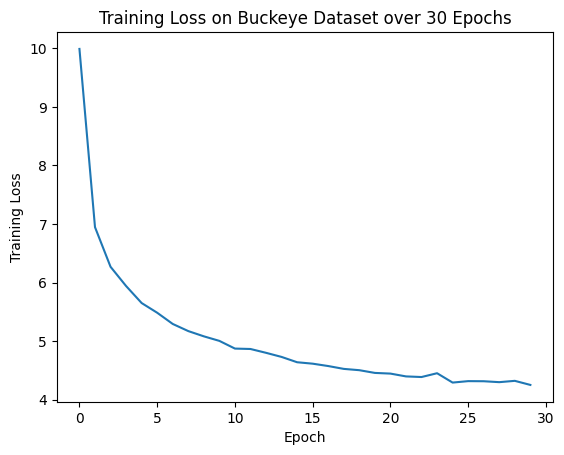

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')
plt.plot(epoch_losses[1])
plt.title('Training Loss on Buckeye Dataset over 30 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

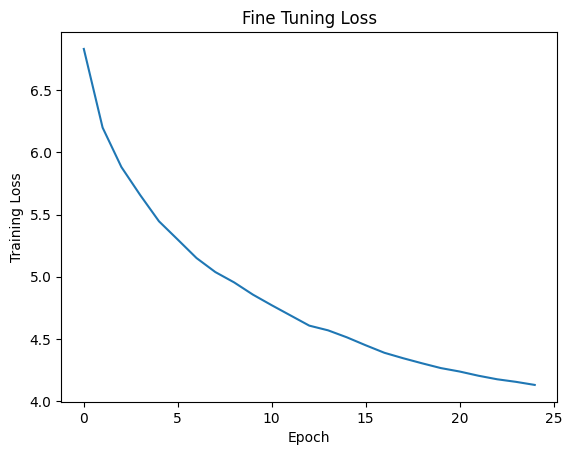

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')
plt.plot(epoch_losses[0])
plt.title('Fine Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

## Testing/Inference

In [ ]:
g2p = G2P()

args = {
    'model': 'temp',
    'load_model': './drive/MyDrive/models/neufa_fine42p30.pt',
    'valid_path': './Buckeye/Buckeye',
}

device = "cuda:0"

if args['model'] == 'base':
    model = NeuFA_base(hparams)
elif args['model'] == 'tep':
    model = NeuFA_TeP(hparams)
elif args['model'] == 'mep':
    model = NeuFA_MeP(hparams)
elif args['model'] == 'temp':
    model = NeuFA_TeMP(hparams)

with open('./Buckeye/test_set.pkl', 'rb') as file:
    valid_files = pickle.load(file)
test_dataset = BuckeyePhoneme('./Buckeye/Buckeye', reduction=hparams.reduction_rate, wavs=valid_files)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.batch_size, shuffle=False, collate_fn=Collate(device))

past_state = torch.load(args['load_model'], map_location='cpu')
model.load_state_dict(past_state['model_state_dict'])

model = model.to(device)
model.eval()

with torch.no_grad():
    predicted = []
    all_data = []
    for data in tqdm(test_dataloader):
        all_data.append(data)
        predicted.append(model(*data[:2]))

    data = [i for i in zip(*all_data)]
    predicted = [i for i in zip(*predicted)]

    for i in range(len(data)):
        data[i] = [k for j in data[i] for k in j]

    for i in range(len(predicted)):
        predicted[i] = [k for j in predicted[i] for k in j]

    predicted[-1] = model.extract_boundary(predicted[-1])

    print(model.boundary_mae(predicted[-1], data[2]))
    # sys.exit()

    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    print(375, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    print(250, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    print(125, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 63]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 63]
    print(63, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    print(32, len(p), model.boundary_mae(p, q))

    count = [0 for i in range(1001)]
    for i in tqdm(range(len(data[0]))):
        file = test_dataset.wavs[i]
        texts, boundaries, p_boundaries = data[0][i], data[2][i], predicted[-1][i]
        texts = [g2p.id2symbol[j-1] for j in texts]
        output=[]

        for j in range(len(texts)):
            output.append([])
            output[-1].append(texts[j])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % boundaries[j][k])
            output[-1].append('%.4f' % p_boundaries[j][0])
            output[-1].append('%.4f' % p_boundaries[j][1])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % (p_boundaries[j][k] - boundaries[j][k]))
                    try:
                        count[int(abs(p_boundaries[j][k] - boundaries[j][k]) * 1000)] += 1
                    except:
                        count[-1] += 1
            output[-1] = '\t'.join(output[-1])

        with open(file.parent / f'{file.stem}.output.txt', 'w') as f:
            f.write('\n'.join(output))

    print(10,   sum(count[:10]), sum(count[:10])/sum(count))
    print(25,   sum(count[10:25]), sum(count[:25])/sum(count))
    print(50,   sum(count[25:50]), sum(count[:50])/sum(count))
    print(100,  sum(count[50:100]), sum(count[:100])/sum(count))
    print(200,  sum(count[100:200]), sum(count[:200])/sum(count))
    print(500,  sum(count[200:500]), sum(count[:500])/sum(count))
    print(1000, sum(count[500:1000]), sum(count[:1000])/sum(count))

  0%|          | 0/734 [00:00<?, ?it/s]

tensor(0.0334, device='cuda:0')
375 11734 tensor(0.0322, device='cuda:0')
250 11719 tensor(0.0317, device='cuda:0')
125 11429 tensor(0.0301, device='cuda:0')
63 9493 tensor(0.0287, device='cuda:0')
32 6106 tensor(0.0276, device='cuda:0')


  0%|          | 0/11738 [00:00<?, ?it/s]

10 87232 0.20407055630936227
25 131795 0.512391802741777
50 161758 0.8908084967014458
100 35092 0.9729027277406073
200 7382 0.9901721798530857
500 3262 0.997803303233051
1000 609 0.9992279979413279


In [ ]:
lengths = []
for f in valid_files:
    lengths.append(get_duration(f, 'Buckeye'))
lengths = np.array(lengths)
print(lengths.mean())
print(lengths.std())
print(float(len(lengths > 1)) / len(lengths))

1.5815618450758218
1.47837613861607
1.0


In [ ]:
lengths = []
for f in IFAPhoneme(4).ids:
    lengths.append(get_duration(f))
lengths = np.array(lengths)
print(lengths.mean())
print(lengths.std())
print(float(len(lengths > 1)) / len(lengths))

0.9442647698229648
0.8278401083520408
1.0


In [ ]:
lengths = []
for f in IFAPhoneme(4, 1).ids:
    lengths.append(get_duration(f))
lengths = np.array(lengths)
print(lengths.mean())
print(lengths.std())
print(float(len(lengths > 1)) / len(lengths))

1.8702573693667444
0.8899225964315931
1.0


In [ ]:
lengths = []
for f in IFAPhoneme(4, 0.75).ids:
    lengths.append(get_duration(f))
lengths = np.array(lengths)
print(lengths.mean())
print(lengths.std())
print(float(len(lengths > 1)) / len(lengths))

1.6414089545522723
0.8889327814955705
1.0


In [ ]:
#test on IFA

g2p = G2P()

args = {
    'model': 'temp',
    'load_model': './drive/MyDrive/models/neufa_fine42p30.pt'
}

device = "cuda:0"

if args['model'] == 'base':
    model = NeuFA_base(hparams)
elif args['model'] == 'tep':
    model = NeuFA_TeP(hparams)
elif args['model'] == 'mep':
    model = NeuFA_MeP(hparams)
elif args['model'] == 'temp':
    model = NeuFA_TeMP(hparams)

test_dataset = IFAPhoneme(reduction=hparams.reduction_rate, min_length = 1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=Collate(device))

past_state = torch.load(args['load_model'], map_location='cpu')
model.load_state_dict(past_state['model_state_dict'])

model = model.to(device)
model.eval()

with torch.no_grad():
    predicted = []
    all_data = []
    for data in tqdm(test_dataloader):
        all_data.append(data)
        predicted.append(model(*data[:2]))

    data = [i for i in zip(*all_data)]
    predicted = [i for i in zip(*predicted)]

    for i in range(len(data)):
        data[i] = [k for j in data[i] for k in j]

    for i in range(len(predicted)):
        predicted[i] = [k for j in predicted[i] for k in j]

    predicted[-1] = model.extract_boundary(predicted[-1])

    print(model.boundary_mae(predicted[-1], data[2]))

    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    print(375, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    print(250, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    print(125, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    print(64, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    print(32, len(p), model.boundary_mae(p, q))

    count = [0 for i in range(1001)]
    for i in tqdm(range(len(data[0]))):
        file_id = test_dataset.ids[i]
        texts, boundaries, p_boundaries = data[0][i], data[2][i], predicted[-1][i]
        texts = [g2p.id2symbol[j-1] for j in texts]
        output=[]

        for j in range(len(texts)):
            output.append([])
            output[-1].append(texts[j])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % boundaries[j][k])
            output[-1].append('%.4f' % p_boundaries[j][0])
            output[-1].append('%.4f' % p_boundaries[j][1])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % (p_boundaries[j][k] - boundaries[j][k]))
                    try:
                        count[int(abs(p_boundaries[j][k] - boundaries[j][k]) * 1000)] += 1
                    except:
                        count[-1] += 1
            output[-1] = '\t'.join(output[-1])

        with open(phoneme_folder / f'{file_id}.output.txt', 'w') as f:
            f.write('\n'.join(output))

    print(10,   sum(count[:10]), sum(count[:10])/sum(count))
    print(25,   sum(count[10:25]), sum(count[:25])/sum(count))
    print(50,   sum(count[25:50]), sum(count[:50])/sum(count))
    print(100,  sum(count[50:100]), sum(count[:100])/sum(count))
    print(200,  sum(count[100:200]), sum(count[:200])/sum(count))
    print(500,  sum(count[200:500]), sum(count[:500])/sum(count))
    print(1000, sum(count[500:1000]), sum(count[:1000])/sum(count))

  0%|          | 0/5148 [00:00<?, ?it/s]

tensor(0.0391, device='cuda:0')
375 5148 tensor(0.0391, device='cuda:0')
250 5146 tensor(0.0383, device='cuda:0')
125 5086 tensor(0.0367, device='cuda:0')
64 4317 tensor(0.0339, device='cuda:0')
32 1142 tensor(0.0306, device='cuda:0')


  0%|          | 0/5148 [00:00<?, ?it/s]

10 47165 0.18092231445537263
25 71074 0.4535582219630829
50 97219 0.8264848940512175
100 31756 0.9482991422828472
200 8610 0.9813266229880472
500 3927 0.9963903763828579
1000 743 0.9992404830221104


In [ ]:
#test on IFA

g2p = G2P()

args = {
    'model': 'temp',
    'load_model': './drive/MyDrive/models/neufa_fine42p30.pt'
}

device = "cuda:0"

if args['model'] == 'base':
    model = NeuFA_base(hparams)
elif args['model'] == 'tep':
    model = NeuFA_TeP(hparams)
elif args['model'] == 'mep':
    model = NeuFA_MeP(hparams)
elif args['model'] == 'temp':
    model = NeuFA_TeMP(hparams)

test_dataset = IFAPhoneme(reduction=hparams.reduction_rate, min_length = 0.75)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=Collate(device))

past_state = torch.load(args['load_model'], map_location='cpu')
model.load_state_dict(past_state['model_state_dict'])

model = model.to(device)
model.eval()

with torch.no_grad():
    predicted = []
    all_data = []
    for data in tqdm(test_dataloader):
        all_data.append(data)
        predicted.append(model(*data[:2]))

    data = [i for i in zip(*all_data)]
    predicted = [i for i in zip(*predicted)]

    for i in range(len(data)):
        data[i] = [k for j in data[i] for k in j]

    for i in range(len(predicted)):
        predicted[i] = [k for j in predicted[i] for k in j]

    predicted[-1] = model.extract_boundary(predicted[-1])

    print(model.boundary_mae(predicted[-1], data[2]))

    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    print(375, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    print(250, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    print(125, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    print(64, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    print(32, len(p), model.boundary_mae(p, q))

    count = [0 for i in range(1001)]
    for i in tqdm(range(len(data[0]))):
        file_id = test_dataset.ids[i]
        texts, boundaries, p_boundaries = data[0][i], data[2][i], predicted[-1][i]
        texts = [g2p.id2symbol[j-1] for j in texts]
        output=[]

        for j in range(len(texts)):
            output.append([])
            output[-1].append(texts[j])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % boundaries[j][k])
            output[-1].append('%.4f' % p_boundaries[j][0])
            output[-1].append('%.4f' % p_boundaries[j][1])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % (p_boundaries[j][k] - boundaries[j][k]))
                    try:
                        count[int(abs(p_boundaries[j][k] - boundaries[j][k]) * 1000)] += 1
                    except:
                        count[-1] += 1
            output[-1] = '\t'.join(output[-1])

        with open(phoneme_folder / f'{file_id}.output.txt', 'w') as f:
            f.write('\n'.join(output))

    print(10,   sum(count[:10]), sum(count[:10])/sum(count))
    print(25,   sum(count[10:25]), sum(count[:25])/sum(count))
    print(50,   sum(count[25:50]), sum(count[:50])/sum(count))
    print(100,  sum(count[50:100]), sum(count[:100])/sum(count))
    print(200,  sum(count[100:200]), sum(count[:200])/sum(count))
    print(500,  sum(count[200:500]), sum(count[:500])/sum(count))
    print(1000, sum(count[500:1000]), sum(count[:1000])/sum(count))

  0%|          | 0/6667 [00:00<?, ?it/s]

tensor(0.0381, device='cuda:0')
375 6667 tensor(0.0381, device='cuda:0')
250 6665 tensor(0.0374, device='cuda:0')
125 6605 tensor(0.0359, device='cuda:0')
64 5836 tensor(0.0334, device='cuda:0')
32 2661 tensor(0.0305, device='cuda:0')


  0%|          | 0/6667 [00:00<?, ?it/s]

10 53883 0.1839751162584249
25 80053 0.4573036239850861
50 109477 0.8310957996735887
100 35162 0.951150975478179
200 9297 0.9828941348392868
500 4065 0.9967734445954344
1000 747 0.9993239598199958


In [ ]:
# #test on IFA

g2p = G2P()

# args = {
#     'model': 'temp',
#     'load_model': './drive/MyDrive/models/neufa_fine42p30.pt'
# }

# device = "cuda:0"

# if args['model'] == 'base':
#     model = NeuFA_base(hparams)
# elif args['model'] == 'tep':
#     model = NeuFA_TeP(hparams)
# elif args['model'] == 'mep':
#     model = NeuFA_MeP(hparams)
# elif args['model'] == 'temp':
#     model = NeuFA_TeMP(hparams)

test_dataset = IFAPhoneme(reduction=hparams.reduction_rate, min_length = 0.75, ids=test_ids)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=Collate(device))

# past_state = torch.load(args['load_model'], map_location='cpu')
# model.load_state_dict(past_state['model_state_dict'])

# model = model.to(device)
model.eval()

with torch.no_grad():
    predicted = []
    all_data = []
    for data in tqdm(test_dataloader):
        all_data.append(data)
        predicted.append(model(*data[:2]))

    data = [i for i in zip(*all_data)]
    predicted = [i for i in zip(*predicted)]

    for i in range(len(data)):
        data[i] = [k for j in data[i] for k in j]

    for i in range(len(predicted)):
        predicted[i] = [k for j in predicted[i] for k in j]

    predicted[-1] = model.extract_boundary(predicted[-1])

    print(model.boundary_mae(predicted[-1], data[2]))

    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    print(375, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    print(250, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    print(125, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    print(64, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    print(32, len(p), model.boundary_mae(p, q))

    count = [0 for i in range(1001)]
    for i in tqdm(range(len(data[0]))):
        file_id = test_dataset.ids[i]
        texts, boundaries, p_boundaries = data[0][i], data[2][i], predicted[-1][i]
        texts = [g2p.id2symbol[j-1] for j in texts]
        output=[]

        for j in range(len(texts)):
            output.append([])
            output[-1].append(texts[j])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % boundaries[j][k])
            output[-1].append('%.4f' % p_boundaries[j][0])
            output[-1].append('%.4f' % p_boundaries[j][1])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % (p_boundaries[j][k] - boundaries[j][k]))
                    try:
                        count[int(abs(p_boundaries[j][k] - boundaries[j][k]) * 1000)] += 1
                    except:
                        count[-1] += 1
            output[-1] = '\t'.join(output[-1])

        # with open(phoneme_folder / f'{file_id}.output.txt', 'w') as f:
        #     f.write('\n'.join(output))

    print(10,   sum(count[:10]), sum(count[:10])/sum(count))
    print(25,   sum(count[10:25]), sum(count[:25])/sum(count))
    print(50,   sum(count[25:50]), sum(count[:50])/sum(count))
    print(100,  sum(count[50:100]), sum(count[:100])/sum(count))
    print(200,  sum(count[100:200]), sum(count[:200])/sum(count))
    print(500,  sum(count[200:500]), sum(count[:500])/sum(count))
    print(1000, sum(count[500:1000]), sum(count[:1000])/sum(count))

100%|██████████| 3165/3165 [01:55<00:00, 27.52it/s]


tensor(0.0282)
375 3165 tensor(0.0282)
250 3165 tensor(0.0282)
125 3134 tensor(0.0271)
64 2761 tensor(0.0266)
32 1227 tensor(0.0254)


100%|██████████| 3165/3165 [00:10<00:00, 300.45it/s]

10 29170 0.2082887051397398
25 43006 0.5153735201291004
50 55394 0.9109149850763321
100 10657 0.987011410536538
200 1166 0.9953372463333476
500 526 0.9990931551061794
1000 117 0.9999285948902503


In [ ]:
# #test on IFA

g2p = G2P()

# args = {
#     'model': 'temp',
#     'load_model': './drive/MyDrive/models/neufa_fine42p30.pt'
# }

# device = "cuda:0"

# if args['model'] == 'base':
#     model = NeuFA_base(hparams)
# elif args['model'] == 'tep':
#     model = NeuFA_TeP(hparams)
# elif args['model'] == 'mep':
#     model = NeuFA_MeP(hparams)
# elif args['model'] == 'temp':
#     model = NeuFA_TeMP(hparams)

test_dataset = IFAPhoneme(reduction=hparams.reduction_rate, min_length = 0.03, ids=test_ids)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=Collate(device))

# past_state = torch.load(args['load_model'], map_location='cpu')
# model.load_state_dict(past_state['model_state_dict'])

# model = model.to(device)
model.eval()

with torch.no_grad():
    predicted = []
    all_data = []
    for data in tqdm(test_dataloader):
        all_data.append(data)
        predicted.append(model(*data[:2]))

    data = [i for i in zip(*all_data)]
    predicted = [i for i in zip(*predicted)]

    for i in range(len(data)):
        data[i] = [k for j in data[i] for k in j]

    for i in range(len(predicted)):
        predicted[i] = [k for j in predicted[i] for k in j]

    predicted[-1] = model.extract_boundary(predicted[-1])

    print(model.boundary_mae(predicted[-1], data[2]))

    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    print(375, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    print(250, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    print(125, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 64]
    print(64, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    print(32, len(p), model.boundary_mae(p, q))

    count = [0 for i in range(1001)]
    for i in tqdm(range(len(data[0]))):
        file_id = test_dataset.ids[i]
        texts, boundaries, p_boundaries = data[0][i], data[2][i], predicted[-1][i]
        texts = [g2p.id2symbol[j-1] for j in texts]
        output=[]

        for j in range(len(texts)):
            output.append([])
            output[-1].append(texts[j])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % boundaries[j][k])
            output[-1].append('%.4f' % p_boundaries[j][0])
            output[-1].append('%.4f' % p_boundaries[j][1])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % (p_boundaries[j][k] - boundaries[j][k]))
                    try:
                        count[int(abs(p_boundaries[j][k] - boundaries[j][k]) * 1000)] += 1
                    except:
                        count[-1] += 1
            output[-1] = '\t'.join(output[-1])

        # with open(phoneme_folder / f'{file_id}.output.txt', 'w') as f:
        #     f.write('\n'.join(output))

    print(10,   sum(count[:10]), sum(count[:10])/sum(count))
    print(25,   sum(count[10:25]), sum(count[:25])/sum(count))
    print(50,   sum(count[25:50]), sum(count[:50])/sum(count))
    print(100,  sum(count[50:100]), sum(count[:100])/sum(count))
    print(200,  sum(count[100:200]), sum(count[:200])/sum(count))
    print(500,  sum(count[200:500]), sum(count[:500])/sum(count))
    print(1000, sum(count[500:1000]), sum(count[:1000])/sum(count))

100%|██████████| 7591/7591 [02:52<00:00, 43.89it/s]


tensor(0.0273)
375 7591 tensor(0.0273)
250 7591 tensor(0.0273)
125 7560 tensor(0.0265)
64 7187 tensor(0.0259)
32 5653 tensor(0.0245)


100%|██████████| 7591/7591 [00:13<00:00, 577.64it/s]

10 39118 0.22589102164322178
25 52376 0.5283417642575012
50 66708 0.9135541542512646
100 12732 0.987076432679648
200 1476 0.9955997505370383
500 633 0.9992550758783175
1000 119 0.9999422539440557


In [ ]:
# g2p = G2P()

# args = {
#     'model': 'temp',
#     'load_model': './drive/MyDrive/models/neufa_fine42p30.pt',
#     'valid_path': './Buckeye/Buckeye',
# }

# device = "cuda:0"

# if args['model'] == 'base':
#     model = NeuFA_base(hparams)
# elif args['model'] == 'tep':
#     model = NeuFA_TeP(hparams)
# elif args['model'] == 'mep':
#     model = NeuFA_MeP(hparams)
# elif args['model'] == 'temp':
#     model = NeuFA_TeMP(hparams)

with open('./Buckeye/test_set.pkl', 'rb') as file:
    valid_files = pickle.load(file)
test_dataset = BuckeyePhoneme('./Buckeye/Buckeye', reduction=hparams.reduction_rate, wavs=valid_files)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams.batch_size, shuffle=False, collate_fn=Collate(device))

# past_state = torch.load(args['load_model'], map_location='cpu')
# model.load_state_dict(past_state['model_state_dict'])

# model = model.to(device)
model.eval()

with torch.no_grad():
    predicted = []
    all_data = []
    for data in tqdm(test_dataloader):
        all_data.append(data)
        predicted.append(model(*data[:2]))

    data = [i for i in zip(*all_data)]
    predicted = [i for i in zip(*predicted)]

    for i in range(len(data)):
        data[i] = [k for j in data[i] for k in j]

    for i in range(len(predicted)):
        predicted[i] = [k for j in predicted[i] for k in j]

    predicted[-1] = model.extract_boundary(predicted[-1])

    print(model.boundary_mae(predicted[-1], data[2]))
    # sys.exit()

    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 375]
    print(375, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 250]
    print(250, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 125]
    print(125, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 63]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 63]
    print(63, len(p), model.boundary_mae(p, q))
    p = [predicted[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    q = [data[-1][i] for i in range(len(data[0])) if data[1][i].shape[0] < 32]
    print(32, len(p), model.boundary_mae(p, q))

    count = [0 for i in range(1001)]
    for i in tqdm(range(len(data[0]))):
        file = test_dataset.wavs[i]
        texts, boundaries, p_boundaries = data[0][i], data[2][i], predicted[-1][i]
        texts = [g2p.id2symbol[j-1] for j in texts]
        output=[]

        for j in range(len(texts)):
            output.append([])
            output[-1].append(texts[j])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % boundaries[j][k])
            output[-1].append('%.4f' % p_boundaries[j][0])
            output[-1].append('%.4f' % p_boundaries[j][1])
            for k in range(2):
                if boundaries[j][k] == -1:
                    output[-1].append('-')
                else:
                    output[-1].append('%.4f' % (p_boundaries[j][k] - boundaries[j][k]))
                    try:
                        count[int(abs(p_boundaries[j][k] - boundaries[j][k]) * 1000)] += 1
                    except:
                        count[-1] += 1
            output[-1] = '\t'.join(output[-1])

        # with open(file.parent / f'{file.stem}.output.txt', 'w') as f:
        #     f.write('\n'.join(output))

    print(10,   sum(count[:10]), sum(count[:10])/sum(count))
    print(25,   sum(count[10:25]), sum(count[:25])/sum(count))
    print(50,   sum(count[25:50]), sum(count[:50])/sum(count))
    print(100,  sum(count[50:100]), sum(count[:100])/sum(count))
    print(200,  sum(count[100:200]), sum(count[:200])/sum(count))
    print(500,  sum(count[200:500]), sum(count[:500])/sum(count))
    print(1000, sum(count[500:1000]), sum(count[:1000])/sum(count))

100%|██████████| 734/734 [03:39<00:00,  3.34it/s]


tensor(0.0350)
375 11734 tensor(0.0335)
250 11719 tensor(0.0327)
125 11429 tensor(0.0306)
63 9493 tensor(0.0289)
32 6106 tensor(0.0274)


100%|██████████| 11738/11738 [00:31<00:00, 373.86it/s]

10 100630 0.23541383989145184
25 134066 0.5490478641276376
50 145450 0.8893136199878351
100 31933 0.9640176858653441
200 9000 0.9850722874654938
500 4867 0.9964581481308192
1000 1048 0.9989098395171478


In [ ]:
#inference class
class NeuFA:

    def __init__(self, model_path='./drive/MyDrive/models/neufa_finep115.pt', device='cpu'):
        self.device = device
        past_state = torch.load(model_path, map_location='cpu')
        self.model = NeuFA_TeMP(hparams)
        self.model.load_state_dict(past_state['model_state_dict'])
        model.to(device)
        self.model.eval()
        self.g2p = G2P()

    def fit_to_words(self, matrix, words):
        phonemes = self.get_phonemes(words)

        result = []
        start = 0
        for word, phoneme in zip(words, phonemes):
            if len(phoneme) > 0:
                result.append(np.mean(matrix[start:start+len(phoneme)], axis=0, keepdims=True))
                start += len(phoneme)
            else:
                result.append(np.zeros((1, matrix.shape[-1])))
        result = np.concatenate(result)
        return result

    def get_words(self, text):
        if os.path.exists(text):
            with open(text) as f:
                text = f.readline().strip('\r\n').lower()
        text = ''.join([i for i in text if i in "abcedfghijklmnopqrstuvwxyz' "])
        words = text.split(' ')
        words = [i for i in words if i != '']

        return words

    def get_phonemes(self, words):
        phonemes = []
        for word in words:
            phonemes += [self.g2p.convert(word)]
        for j, phoneme in enumerate(phonemes):
            phonemes[j] = [i[:-1] if i.endswith(('0', '1', '2')) else i for i in phoneme]
            phonemes[j] = [self.g2p.symbol2id[i] + 1 for i in phoneme if i in self.g2p.symbols]
        return phonemes

    def load_text(self, text):
        words = self.get_words(text)
        phonemes = self.get_phonemes(words)
        phonemes = [j for i in phonemes for j in i]
        phonemes = np.array(phonemes)
        return torch.IntTensor(phonemes).to(self.device)

    def load_wav(self, wav):
        if os.path.exists(wav):
            wav, sample_rate = librosa.load(wav, mono=True)
        mfcc = librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40), fmax=8000)
        delta = librosa.feature.delta(mfcc, width=3, order=1)
        delta2 = librosa.feature.delta(mfcc, width=3, order=2)
        mfcc = np.concatenate([mfcc, delta, delta2]).T.astype(np.float32)
        mean = mfcc.mean(axis=0, keepdims=False)
        std = mfcc.std(axis=0, keepdims=False)
        mfcc -= mean
        mfcc /= std
        return torch.FloatTensor(mfcc).to(self.device)

    def extract_boundary(self, p_boundaries, threshold=0.5):
        result = []
        for p_boundary in p_boundaries:
            result.append([])
            result[-1].append(np.array([i[i<threshold].shape[0] / 100 for i in p_boundary[:,0,:]]))
            result[-1].append(np.array([i[i<threshold].shape[0] / 100 for i in p_boundary[:,1,:]]))
            result[-1] = np.stack(result[-1], axis=-1)
        return result

    def align(self, text, wav):
        text = [self.load_text(text)]
        wav = [self.load_wav(wav)]
        with torch.no_grad():
            _, _, w1, w2, _, _, _, _, boundaries = self.model(text, wav)
            boundaries = self.extract_boundary(boundaries)
        return boundaries[0], w1[0].cpu().numpy(), w2[0].cpu().numpy()

In [ ]:
args = {
    'model': 'temp',
    'train_path': './Librispeech',
    'load_model': None,
    'name': None,
    'train_path': './LibriSpeech',
    'dev_path': './drive/MyDrive/BuckeyeTrain',
    'valid_path': './drive/MyDrive/BuckeyeTrain',
    'gpu': -1,
    'input_text': None,
    'input_wav': None,
    'input_folder': None,
}

if args['gpu'] < 0:
    neufa = NeuFA()
else:
    neufa = NeuFA(device=f'cuda:{args["gpu"]}')

if args['input_folder']:
    texts = [i for i in Path(args['input_folder']).rglob('*.txt')]
    for text in tqdm(texts):
        wav = text.parent / f'{text.stem}.wav'
        words = neufa.get_words(text)
        boundaries, w_tts, w_asr = neufa.align(text, wav)
        #np.save(text.parent / f'{text.stem}.boundary.npy', boundaries)
        np.save(text.parent / f'{text.stem}.wasr.npy', neufa.fit_to_words(w_asr, words))
        #np.save(text.parent / f'{text.stem}.wtts.npy', w_tts)
else:
    boundaries, w1, w2 = neufa.align(args['input_text'], args['input_wav'])
    words = neufa.get_words(args['input_text'])
    phonemes = neufa.get_phonemes(words)
    start = 0
    for word, phoneme in zip(words, phonemes):
        if len(phoneme) > 0:
            #l = np.min(boundaries[start:start+len(phoneme)])
            #r = np.max(boundaries[start:start+len(phoneme)])
            l = boundaries[start, 0]
            r = boundaries[start+len(phoneme) - 1, 1]
            t = r - l
            print(word, l, r, '%.2f' % t)
        else:
            print(word, '-', '-')

        for p, boundary in zip(phoneme, boundaries[start:start+len(phoneme)]):
            print(neufa.g2p.id2symbol[p-1], boundary)

        start += len(phoneme)